In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.cluster.vq import kmeans, vq
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

K means clustering on tiles taken from an image

(480, 640)


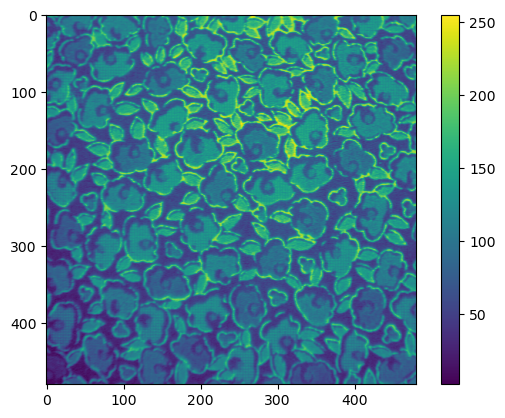

In [156]:
image_number = 10
# dimensionality (N) of subspace = 64
tile_w = 8
 

image = cv2.imread(f"Dataset/Image{image_number}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
mindim = np.min(image.shape)
image = image[:mindim, :mindim]

plt.imshow(image)
plt.colorbar()
plt.show();

In [157]:
def return_tiles(image, tile_width):
    """
    image: A 2D array
    tile_width: the width of a square tile
    """
    width, height = image.shape

    # Calculate the number of tiles in each dimension
    num_tiles_x = width // tile_width
    num_tiles_y = height // tile_width

    # Initialize an empty array to store tiles
    # Reshape the image into tiles
    tiles = image[:num_tiles_y * tile_width, :num_tiles_x * tile_width].reshape(
        num_tiles_y, tile_width, num_tiles_x, tile_width)

    # Transpose the axes to get the desired shape
    tiles2d = tiles.transpose(0, 2, 1, 3).reshape(num_tiles_y, num_tiles_x, tile_width, tile_width)
    tiles1d = tiles2d.reshape(num_tiles_y*num_tiles_x, tile_width*tile_width)

    return tiles2d, tiles1d

In [158]:
im_tiles2d, im_tiles1d = return_tiles(image, tile_w)
print(im_tiles2d.shape)
print(im_tiles1d.shape)

(60, 60, 8, 8)
(3600, 64)


In [159]:
def visualize_tiles(tiles_array):
    num_tiles_y, num_tiles_x, tile_width, _ = tiles_array.shape

    #subplot with a grid of tiles
    fig, axes = plt.subplots(num_tiles_y, num_tiles_x, figsize=(10, 10))

    # Iterate through each tile and display
    for i in range(num_tiles_y):
        for j in range(num_tiles_x):
            axes[i, j].imshow(tiles_array[i, j, :, :])
            axes[i, j].axis('off')  # Turn off axis labels

    plt.show()

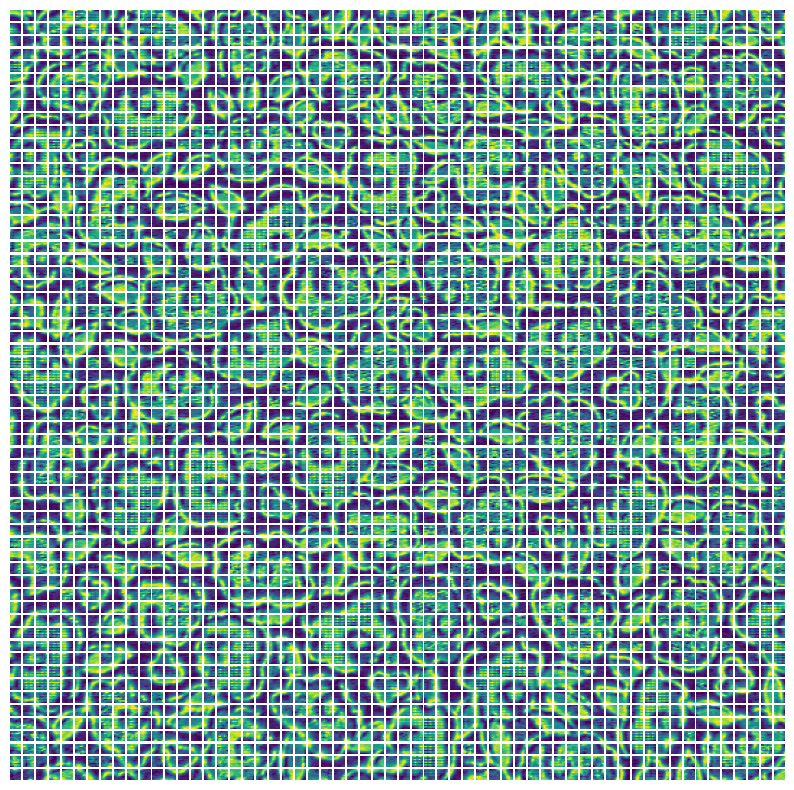

In [160]:
visualize_tiles(im_tiles2d)

In [161]:
im_tiles1d = im_tiles1d.astype(float)

### Decide the number of clusters
* And if needed, change the num_clusters argument in the start 

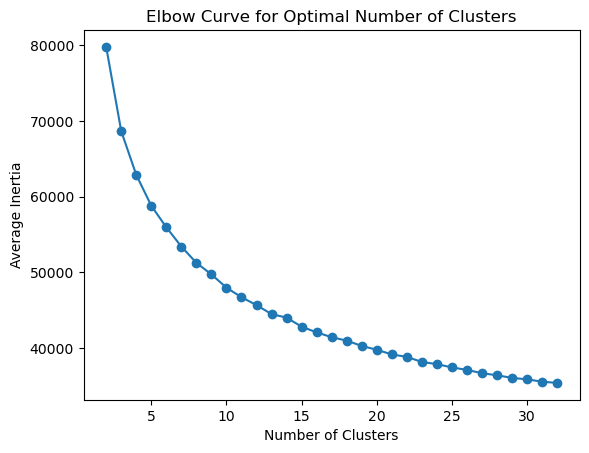

[79788.67667828541,
 68663.56566865557,
 62888.68989838005,
 58805.07255802424,
 55963.376439633204,
 53417.53737149209,
 51268.82240443158,
 49741.7687108743,
 47984.03847924134,
 46732.01825402273,
 45679.57098588905,
 44497.79890933025,
 44031.58240184632,
 42834.83817966882,
 42080.31322238506,
 41444.75366840837,
 40991.418167294316,
 40290.50544042527,
 39784.69735850677,
 39169.72402865522,
 38845.53135792955,
 38175.3309839271,
 37888.117151277096,
 37451.79712572933,
 37124.88442549743,
 36687.39440154186,
 36413.49294168978,
 36070.3713017308,
 35877.578221070195,
 35566.35870653631,
 35403.80326307253]

In [162]:
def calculate_inertia(data, centroids, cluster_indices):
    # Calculate within-cluster sum of squared distances
    # print(type(cluster_indices), cluster_indices.shape)
    distances = np.sum((data - centroids[cluster_indices]) ** 2)
    inertia = distances / len(data)
    return inertia

def elbow_method(data, max_clusters=32):
    inertias = []

    for num_clusters in range(2, max_clusters + 1):
        centroids, distortion = kmeans(data, num_clusters)
        cluster_indices, _ = vq(data, centroids)
        inertia = calculate_inertia(data, centroids, cluster_indices)
        inertias.append(inertia)

    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Curve for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Inertia')
    plt.show()

    return inertias

elbow_method(im_tiles1d, 32)

In [163]:
num_clusters = 20 

In [164]:
# Perform K-means clustering
# Adjust the number of clusters as needed
centroids, _ = kmeans(im_tiles1d, num_clusters)
print('centroids shape:', centroids.shape)

#vector quatization
cluster_indices, _ = vq(im_tiles1d, centroids)
print('cluster_indices shape:', cluster_indices.shape)

# # Visualise the clusters using PCA
# pca = PCA(n_components=2)
# im_tiles1d_reduced = pca.fit_transform(im_tiles1d)

# # Visualize the clustering in a 2D plot
# plt.scatter(im_tiles1d_reduced[:, 0], im_tiles1d_reduced[:, 1], c=cluster_indices, cmap='viridis', alpha=0.8)
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Cluster Centroids')
# plt.title('K-means Clustering with PCA Dimensionality Reduction')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.show()

centroids shape: (20, 64)
cluster_indices shape: (3600,)


Arranging clusters, means and medoids

In [165]:
def calculate_medoid(cluster):
    """
    cluster: an mxN array of m vectors in a cluster
    """
    # Pairwise distances between points in the cluster
    distances = cdist(cluster, cluster, metric='euclidean')
    total_distances = np.sum(distances, axis=1)
    medoid_index = np.argmin(total_distances)

    # Medoid is the data point with the minimum total distance
    medoid = cluster[medoid_index]

    return medoid

def get_cluster_medoids(data, cluster_indices):
    """
    Inputs:
    data: an mxN array of m data vectors (points)
    cluster_indices: an mx1 array of m cluster indices

    Returns:
    clusters: a dictionary, indexed by cluster number and values are clustered arrays of data
    mediods: a dictionary, indexed by cluster number and values are the medoid data vector
    means: a dictionary, '' '' values are means
    
    """
    unique_clusters = np.unique(cluster_indices)

    # Initialise a dictionary to store clusters
    clusters = {cluster: [] for cluster in unique_clusters}

    # Populate clusters dictionary with data points
    for i, cluster_index in enumerate(cluster_indices):
        clusters[cluster_index].append(data[i])

    # Calculate medoid for each cluster
    medoids = {cluster: calculate_medoid(np.array(points)) for cluster, points in clusters.items()}
    means = {cluster: np.mean(np.array(points), axis=0) for cluster, points in clusters.items()}

    return clusters, medoids, means

Centred Clusters

In [166]:
clustered_data, cluster_medoids, cluster_means = get_cluster_medoids(im_tiles1d, cluster_indices)
print ('keys of clustered data' ,clustered_data.keys())
print ('cluster means[0] has shape' , cluster_means[0].shape)
print ('clustered data[0] has shape' ,np.array(clustered_data[0]).shape)

def get_centered_clusters(clustered_data, cluster_means):
    centered_clusters = {cluster: (np.array(clustered_data[cluster])-cluster_means[cluster]) for cluster in clustered_data.keys()}
    return centered_clusters

centered_clusters = get_centered_clusters(clustered_data, cluster_means)

keys of clustered data dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
cluster means[0] has shape (64,)
clustered data[0] has shape (105, 64)


In [167]:
#check for mean zero--> checked
summa = 0
for i in range(num_clusters):
    summa += centered_clusters[i].sum()
print (summa)

4.0245140553452075e-11


In [168]:
def pca_for_cluster(cluster):
    """ 
    Inputs:
    cluster- mxN centered array of vectors from a single cluster

    Returns:
    cluster_pca
    """
    assert isinstance(cluster, np.ndarray)

    pca = PCA()
    cluster_pca = pca.fit_transform(cluster)
    pca_vectors = pca.components_
    # print('pca vectors shape:', pca_vectors.shape)


    #padding to make the cumsum array have data_dim(8x8=64) length
    data_dim = cluster.shape[-1] 
    padding_size = max(0, data_dim - len(pca.explained_variance_ratio_))
    expl_var_ratio_cumul = np.cumsum(np.pad(pca.explained_variance_ratio_, (0, padding_size), 'constant', constant_values=0))

    return cluster_pca, expl_var_ratio_cumul, pca_vectors

cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(centered_clusters[0])

Cluster 0 basis vectors shape: (11, 64)
Cluster compression when pruning 0.90 variance is 0.1048
--------------------
Cluster 1 basis vectors shape: (11, 64)
Cluster compression when pruning 0.90 variance is 0.1111
--------------------
Cluster 2 basis vectors shape: (11, 64)
Cluster compression when pruning 0.90 variance is 0.1279
--------------------
Cluster 3 basis vectors shape: (15, 64)
Cluster compression when pruning 0.90 variance is 0.0649
--------------------
Cluster 4 basis vectors shape: (10, 64)
Cluster compression when pruning 0.90 variance is 0.0602
--------------------
Cluster 5 basis vectors shape: (13, 64)
Cluster compression when pruning 0.90 variance is 0.0977
--------------------
Cluster 6 basis vectors shape: (10, 64)
Cluster compression when pruning 0.90 variance is 0.1124
--------------------
Cluster 7 basis vectors shape: (11, 64)
Cluster compression when pruning 0.90 variance is 0.1549
--------------------
Cluster 8 basis vectors shape: (11, 64)
Cluster compress

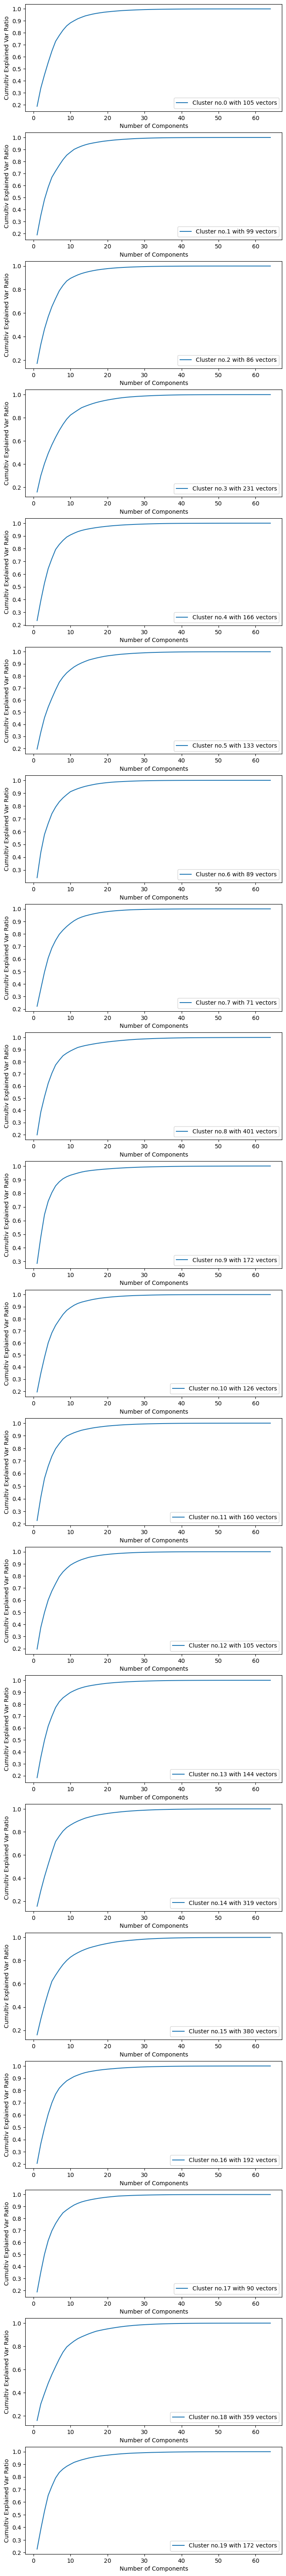

In [169]:
num_clusters = len(centered_clusters)
fig, axs = plt.subplots(nrows= num_clusters, ncols =1, figsize=(8,4* num_clusters))

for i, (cluster_key, points) in enumerate(centered_clusters.items()):
    cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(points)

    # find the index that reaches 0.9 cumsum variability
    t_exp = 0.9
    cutidx = np.argmax(expln_var_cum >= t_exp)
    basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:cutidx]))
    print('Cluster %d basis vectors shape:'%(cluster_key), basis.shape)
    print('Cluster compression when pruning %.2f variance is %.4f'%(t_exp, basis.shape[0]/points.shape[0]))
    print('--------------------')
                      
    axs[i].plot(range(1, len(expln_var_cum) + 1), expln_var_cum, label='Cluster no.%d with %d vectors'%(cluster_key, points.shape[0]))
    axs[i].set_xlabel('Number of Components')
    axs[i].set_ylabel('Cumultiv Explained Var Ratio')
    axs[i].legend()

plt.savefig('results/Patching_Image_%d.pdf'%(image_number))
plt.show()